In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Depth Estimation <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/depth_estimation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = os.path.dirname(os.getcwd())
    sys.path.append(REPO_PATH)
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
force_cudnn_initialization()

## Utilities

In [3]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F

from dinov2.eval.depth.models import build_depther


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

## Load pretrained backbone

In [17]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /media/home/ycwu/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


## Load pretrained depth head

In [18]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "linear" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_nyu_linear_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (softmax): Softmax(dim=1)
    (conv_depth): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

## Load sample image

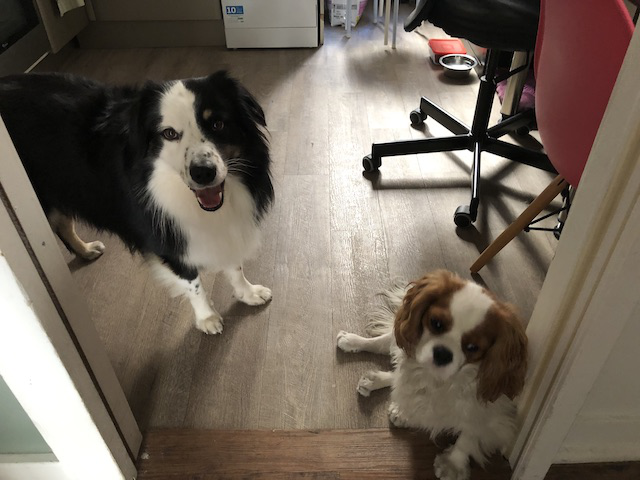

In [19]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

## Estimate depth on sample image

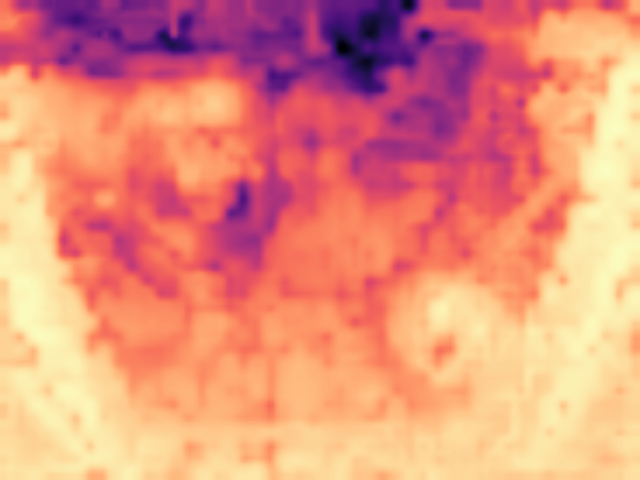

In [20]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)

In [21]:
import os, glob
import numpy as np
from torchvision import transforms
from PIL import Image
import tqdm

def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def compute_error_metrics(ground_truth, output):
    '''
    Computation of error metrics between predicted and ground truth depths
    '''

    thresh = np.maximum((ground_truth / output), (output / ground_truth))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (ground_truth - output) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(ground_truth) - np.log(output)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(ground_truth - output) / ground_truth)

    sq_rel = np.mean(((ground_truth - output) ** 2) / ground_truth)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3


class NYUv2TestingDataset(torch.utils.data.Dataset):
    '''
    Dataset for fetching:
        (1) image
        (2) ground truth depth map (optional)

    Arg(s):
        dataset_path : list[str]
            paths to NYUv2 testing directory
    '''

    def load_image(self, path, resize_factor=1):
        '''
        Loads an image as Pillow image

        Arg(s):
            path : str
                path to 16-bit PNG file
            resize_factor : float

        Returns:
            Image : Pillow image
        '''

        image = Image.open(path).convert('RGB')
        image = image.resize((resize_factor * image.width, resize_factor * image.height))

        return image

    def load_depth(self, path, multiplier=256.0, data_format='HW'):
        '''
        Loads a depth map from a 16-bit PNG file

        Arg(s):
            path : str
                path to 16-bit PNG file
            multiplier : float
                multiplier for encoding float as 16/32 bit unsigned integer
            data_format : str
                HW, CHW, HWC
        Returns:
            numpy[float32] : depth map
        '''

        # Loads depth map from 16-bit PNG file
        z = np.array(Image.open(path), dtype=np.float32)

        # Assert 16-bit (not 8-bit) depth map
        z = z / multiplier
        z[z <= 0] = 0.0

        # Expand dimensions based on output format
        if data_format == 'HW':
            pass
        elif data_format == 'CHW':
            z = np.expand_dims(z, axis=0)
        elif data_format == 'HWC':
            z = np.expand_dims(z, axis=-1)
        else:
            raise ValueError('Unsupported data format: {}'.format(data_format))

        return z

    def __init__(self, dataset_dirpath, resize_factor=1):

        assert os.path.exists(dataset_dirpath), dataset_dirpath

        self.image_paths = sorted(glob.glob(
            os.path.join(dataset_dirpath, 'images', '*.png')))

        self.ground_truth_paths = sorted(
            glob.glob(os.path.join(dataset_dirpath, 'depths', '*.png')))
        
        assert len(self.image_paths) == len(self.ground_truth_paths)

        self.n_sample = len(self.image_paths)

        self.resize_factor = resize_factor
        self.transform = make_depth_transform()

        self.data_format = 'CHW'

    def __getitem__(self, index):

        # Load image
        image = self.load_image(self.image_paths[index])
        image = self.transform(image)

        # Load depth
        depth = self.load_depth(self.ground_truth_paths[index])

        return image, depth

    def __len__(self):
        return self.n_sample
    
'''
Reads dataset
'''
repo_root_dirpath = os.path.join("/", *(os.getcwd().split(os.sep)[:-3]))
nyu_v2_testing_dataset_dirpath = os.path.join(repo_root_dirpath, 'data', 'nyu_v2', 'testing')

test_dataloader = torch.utils.data.DataLoader(
    NYUv2TestingDataset(
        dataset_dirpath=nyu_v2_testing_dataset_dirpath,
        resize_factor=1),
    batch_size=1,
    shuffle=False,
    num_workers=0,
    drop_last=False)

'''
Define error metrics
'''
abs_rel_errors = np.zeros(test_dataloader.dataset.n_sample)
sq_rel_errors = np.zeros(test_dataloader.dataset.n_sample)
rmse_errors = np.zeros(test_dataloader.dataset.n_sample)
rmse_log_errors = np.zeros(test_dataloader.dataset.n_sample)
a1_accuracies = np.zeros(test_dataloader.dataset.n_sample)
a2_accuracies = np.zeros(test_dataloader.dataset.n_sample)
a3_accuracies = np.zeros(test_dataloader.dataset.n_sample)

'''
Inference and evaluate on ground truth
'''
for idx, (image, ground_truth) in enumerate(tqdm.tqdm(test_dataloader)):

    image = image.to("cuda")
    with torch.inference_mode():
        pass
        output = model.whole_inference(image, img_meta=None, rescale=True)
    
    # Normalize output
    min_value, max_value = output.min(), output.max()
    normalized_values = (output - min_value) / (max_value - min_value)

    # Convert from normalized inverse depth to depth
    # depth = 1.0 / output
    depth = np.squeeze(output.cpu().numpy())
    
    # Perform median scaling
    ground_truth = np.squeeze(ground_truth.cpu().numpy())
    mask = np.where(ground_truth > 0, 1, 0)
    ground_truth = ground_truth * mask
    depth = depth * mask

    scale = np.median(ground_truth) / np.median(depth)
    depth = depth * scale

    # Evaluate depth
    abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3 = compute_error_metrics(ground_truth, depth)
    # depth_image = render_depth(depth)
    # display(depth_image)
    # depth_image = render_depth(ground_truth)
    # display(depth_image)
    abs_rel_errors[idx] = abs_rel
    sq_rel_errors[idx] = sq_rel
    rmse_errors[idx] = rmse
    rmse_log_errors[idx] = rmse_log
    a1_accuracies[idx] = a1
    a2_accuracies[idx] = a2
    a3_accuracies[idx] = a3

# Take mean over evaluation scores
abs_rel_mean = np.mean(abs_rel_errors)
sq_rel_mean = np.mean(sq_rel_errors)
rmse_mean = np.mean(rmse_errors)
rmse_log_mean = np.mean(rmse_log_errors)
a1_mean = np.mean(a1_accuracies)
a2_mean = np.mean(a2_accuracies)
a3_mean = np.mean(a3_accuracies)
print(abs_rel_errors)
# Print scores
print('Evaluation results:')
print('{:>8}  {:>8}  {:>8}  {:>8}  {:>8}  {:>8}  {:>8}'.format(
    'AbsRel', 'SqRel', 'RMSE', 'RMSE_log', 'a1', 'a2', 'a3'))
print('{:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}'.format(
    abs_rel_mean, sq_rel_mean, rmse_mean, rmse_log_mean, a1_mean, a2_mean, a3_mean))


  0%|          | 1/1449 [00:00<03:08,  7.67it/s]

100%|██████████| 1449/1449 [03:16<00:00,  7.37it/s]

[0.06251552 0.07599968 0.15626201 ... 0.04444675 0.05408898 0.0504474 ]
Evaluation results:
  AbsRel     SqRel      RMSE  RMSE_log        a1        a2        a3
   0.093     0.054     0.373     0.127     0.916     0.985     0.996
